# Homework 4 - Recommendation systems and clustering everywhere

## Part 1: Recommendation system

1.1 Analyzing e fixing stuff

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import time # used to measure computational time
from pyspark import SparkContext, SparkConf # used for MapReduce
from pyspark.sql import SparkSession # used for MapReduce
from scipy.stats import chi2_contingency # used to perform the chi-squared test
from sklearn.preprocessing import StandardScaler # used for normalization
from sklearn.preprocessing import LabelEncoder # used for categorical features preprocessing
from sklearn.decomposition import PCA # used for dimensionality reduction (PCA)
from sklearn.cluster import KMeans # used as baseline to compare custom kmeans
from kmodes.kprototypes import KPrototypes # suggested by chatgpt
from sklearn.metrics import silhouette_score # used to calculate silhouette score
from tqdm.auto import tqdm # Used for progress bar
from functools import reduce # Used in kmeans++ to filter out selected centroids
from pyspark.sql.functions import lit # Used in kmeans++ to filter out selected centroids
import warnings # Used to suppress FutureWarnings derived from pyspark modules
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Initialize Spark session, leveraging all available cores
conf = SparkConf().setAppName('ADM_HW4_G17')\
                  .setMaster('local[*]')\
                  .set('spark.ui.showConsoleProgress', False) # Hide the default progress bar
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
sc.setLogLevel('ERROR') # Change log level to suppress warnings raised if the cores of computer are not enough

In [3]:
tsv_path = "vodclickstream_uk_movies_03.csv"

Netflix = pd.read_csv(tsv_path)

In [5]:
Netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


We want to change datetime in this way, we can work with this data

In [6]:
Netflix.datetime = pd.to_datetime(Netflix.datetime)
Netflix.release_date = pd.to_datetime(Netflix.release_date, errors='coerce')

We Will use an LSH algorithm and to use it we need shingles, so we will change he "genres" features in a way taìhat we can access to each genre 

In [7]:
Netflix.genres.apply(lambda row: row.split(','))
Netflix['genres_list'] = ''
Netflix['genres_list'] = Netflix.genres.apply(lambda row: [word.strip() for word in row.split(',')])

In [8]:
#We add the clicks feature to know how many time each user watched that film, in this way we don't lose the info of which film
#each user wathced a lot of times
Netflix['clicks'] = 1
user_clicks = Netflix.groupby(['user_id', 'title', 'genres']).size().reset_index(name='clicks')

# Sort the DataFrame by clicks in descending order for each user
user_clicks_sorted = user_clicks.sort_values(by=['user_id', 'clicks'], ascending=[True, False])

# Group by user_id and take the top 10 movies for each user
top_10_movies_per_user = user_clicks_sorted.groupby('user_id').head(10)

# Display the result (title, genres_list, and clicks of the top 10 movies for each user)
top_10_movies_per_user[['user_id', 'title', 'genres', 'clicks']].head()

,user_id,title,genres,clicks
0,00004e2862,Hannibal,"Crime, Drama, Thriller",1
6,000052a0a0,Looper,"Action, Drama, Sci-Fi, Thriller",9
3,000052a0a0,Frailty,"Crime, Drama, Thriller",3
5,000052a0a0,Jumanji,"Adventure, Comedy, Family, Fantasy",3
7,000052a0a0,Resident Evil,"Action, Horror, Sci-Fi",2


we want a matrix that remind which genre each user watched

In [9]:
all_genres = set(genre for genres_list in Netflix['genres_list'] for genre in genres_list)# avoid doubles
all_genres=list(all_genres)
all_user_ids = Netflix['user_id'].unique()
matrix2 = pd.DataFrame(0, index=all_genres, columns=all_user_ids)

# We put a 1 if the user saw a film of that type
for index, row in Netflix.iterrows():
    user_id = row['user_id']
    genres_list = row['genres_list']
    matrix2.loc[genres_list, user_id] = 1

#matrix2

1.2 Minhash Signatures

We want to simulate the permutation od the rows, to do it we use an hash function that we will be fixed after the start of the procedure. this is a procedure that we need to create a signature Matrix, also To reduce the number of calculation and comparison we want to create a signature matrix and divide this in band, we will use numpy to speed-up all the procedure

In [10]:
def hash_function(x,m,a,b):
  p=31
  c=((a*x+b)%p)
  return(c)


In [27]:
import random
import numpy as np
import pandas as pd

k = 19
num_rows = matrix2.shape[0]

#we choose the parameter of the hash formula
a = [random.randint(1, 100) for _ in range(k+1)]
b = [random.randint(1, 100) for _ in range(k+1)]
#initialization of the signature matrix
Signature_hash = np.full((k+1, len(all_user_ids)), 10000)
m=-1#temporary number that we need because the resulting matrix will be a numpy
for j in all_genres:
    m+=1
    s=-1 #same reason of m
    for h in all_user_ids:
        s+=1
        if matrix2.loc[j, h] == 1:

          for i in range(k+1):
            #we choosed to keep the min value, like in the paper that was proposed in the HW
            Signature_hash[i,s]=min(hash_function(m,113,a[i],b[i]),Signature_hash[i,s])



#Signature_hash
#to work again with the user_ids we want the matrix like a Dataframe
Signature_hash_df = pd.DataFrame(Signature_hash, index=range(k+1), columns=all_user_ids)

1.3 LSH Algorithm

The LSH is the combination of the following passages, now the important thing is in how many buckets we want to divide the users. We used this parameters for the buckets, bands because after we tried a lot we found that this was a good compromise for to obtain a good solution in a good amount of time

In [28]:
#Band
#we want to divide the band to reduce the number of comparison, we know that more rows will mean an higher
#precision but we will have an higher cost of calculation
rows_per_band = 5
num_bands = k // rows_per_band

buckets = {}

for band_index in range(num_bands+1):
  n = [random.randint(1, 100) for _ in range(rows_per_band+1)]

  for i in all_user_ids:
    hash_values=0
    # isolatung the column and the rows
    start_row = band_index * rows_per_band
    end_row = ((band_index + 1) * rows_per_band)-1
    v=Signature_hash_df.loc[start_row:end_row,i]
    #we hash again this value and we will use it like a key for a dictionary, in this
    #way we can divide the users, the users in the same bucket will be more similar
    for g in range(len(v)):
      hash_values+=v[g+band_index * rows_per_band]*n[g]
    hash_values=hash_values%41
    if hash_values not in buckets:
      buckets[hash_values] = []
    buckets[hash_values].append(i)

We will calculate the Similarity with the Jaccard Similarity,
so number of buckets were both users are present divided by the number of buckets where it is present alone

In [29]:
def similarity(user1, user2):

    counter=0#we need this to calculate in how many buckets that they are present
    key=buckets.keys()
    for s in key:
      if user1 in buckets[s] and user2 in buckets[s]:
        counter+=1
    similarity_value=counter/(num_bands+1)

    return similarity_value


To find the 2 user more similar to one we will use the function described before iterating it on all the users of the same buckets

In [30]:
def two_most_similar(user):
    v = []
    key=buckets.keys()
    for k in key:
        if user in buckets[k]:
            # We don't want to calculate the similarity with each other user, but only with the users of the same bucket
            for h in buckets[k]:
                if h != user:
                    sim = similarity(user, h)
                    v.append((h, sim))

    # Ordering with the higher similarity
    v=list(set(v))
    sorted_list = sorted(v, key=lambda x: x[1], reverse=True)

    # We need only the best 2
    best = sorted_list[:2]

    return best

In [31]:
def Raccomandation(user):
  #2 temporary variable
  clicks1=[]
  clicks2=[]

  best=two_most_similar(user)#finding the most 2 similar users to the one we are searching
  users,sim=zip(*best)
  users_list=list(users)
  #we take the film for each user
  movies_for_user1 = top_10_movies_per_user.loc[top_10_movies_per_user['user_id'] == users_list[0], 'title']
  movies_for_user2 = top_10_movies_per_user.loc[top_10_movies_per_user['user_id'] == users_list[1], 'title']
 #first we want the movies that they have in common
  tip=list(set(movies_for_user1).intersection(set(movies_for_user2)))

  if len(tip)<5: #if we haven't enough film

    temp_v = set(movies_for_user1) - set(tip) #we take the film that are diffirent for fist user
    temp_v = pd.Series(list(temp_v))
    #the following passages are to order in base of clicks
    for g in temp_v:
      clicks1.append(top_10_movies_per_user.loc[(top_10_movies_per_user['user_id'] == users_list[0]) & (top_10_movies_per_user['title'] == g),'clicks'].values)
    temp=zip(temp_v,clicks1)
    best_df = pd.DataFrame(temp, columns=['title', 'clicks'])
    best = best_df.sort_values(by='clicks', ascending=False).head(5)
    a=5-len(tip) #a indicates the film that i am missing
    if a<= len(best): #now we have enough films
      raccomandation=best[:a]
      titles=raccomandation['title'].tolist()
      final=tip+titles
    else: #we still haven't enough films
      titles=best['title'].tolist()
      final = list(tip) + list(titles)
       #we repeat the same process that we did for the first user to the second user
      temp_2 = list(set(movies_for_user2) - set(tip))

      for g in temp_2:
        clicks2.append(top_10_movies_per_user.loc[(top_10_movies_per_user['user_id'] == users_list[1]) & (top_10_movies_per_user['title'] == g),'clicks'].values)
      temp=zip(temp_2,clicks2)
      best_df = pd.DataFrame(temp, columns=['title', 'clicks'])
      best = best_df.sort_values(by='clicks', ascending=False)
      a=5-len(final)
      raccomandation=best[:a] 

      titles2=raccomandation['title'].tolist()
      final=final+titles2


  elif len(tip)>6: #we have too much film , so we order for the click and then take only the best one
    for h in tip:
      clicks.append(top_10_movies_per_user.loc[(top_10_movies_per_user['user_id'] == users_list[0]) & (top_10_movies_per_user['title'] == h), 'clicks']+top_10_movies_per_user.loc[(top_10_movies_per_user['user_id'] == users_list[1])& (top_10_movies_per_user['title'] == h), 'clicks'])
    temp=zip(tip,clicks)
    best_df = pd.DataFrame(temp, columns=['title', 'clicks'])
    best = best_df.sort_values(by='clicks', ascending=False).head(5)
    titles=best['title'].tolist()
    final = list(tip) + list(titles)

  return(final)


In [32]:
Query=Raccomandation('2428de4ee1')
Query

['Christmas Inheritance',
 'A Christmas Prince',
 'Fallen',
 'Budapest',
 'Deadly Scholars']

## Part 2: Grouping Users together!

In this part, multiple **clustering** algorithms will be explored with the objective of grouping Netflix users on basis of their similarity. Several stages are required to do so. 

### 2.1: Feature Engineering

Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as **feature engineering**.  
In this case, the dataset provided contains informations (such as user_id, title of movie, etc.) about every interaction on the platform between 2017 and 2019. The following code is used to preprocess it and build a new dataset where each row is associated to a unique user, storing informations about their behaviour in 15 features (5 mandatory, 10 arbitrary).

In [5]:
# Re-import original dataset
df = pd.read_csv(tsv_path)

# Preprocess release_date (drop NA)
df['release_date'] = df['release_date'].replace('NOT AVAILABLE', np.nan)
df = df.dropna(subset = ['release_date'])
# Preprocess duration (remove rows where duration < 0)
df = df[df.duration >= 0]
# Preprocess datetime (change its type)
df['datetime'] = pd.to_datetime(df['datetime'])
# Remove duplicates
df = df.drop_duplicates()
# Preprocess genres (make sure that it's a list of genres instead of a string)
df['genres'] = df['genres'].astype(str)
df['genres'] = df['genres'].apply(lambda x: x.split(','))


# Display the preprocessed dataset
display(df.shape)
display(df.head())

(606422, 7)

,datetime,duration,title,genres,release_date,movie_id,user_id
58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe
58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510
58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Fam...",2004-11-19,a80d6fc2aa,a57c992287


In [6]:
# Create the new dataframe, which will store data for each user
df_processed = pd.DataFrame(df.user_id.unique(), columns = ['user_id'])

#### Mandatory Features

a) **Favourite genre**: the genre on which the user spent the most time

In [7]:
# Explode the 'genres' column into multiple rows and calculate the time every user spent on each genre
grouped_df = df.explode('genres').groupby(['user_id', 'genres'], as_index = False).aggregate({'duration':'sum'})

# Take the most viewed genre for each user
idx = grouped_df.groupby('user_id')['duration'].idxmax()
result = grouped_df.loc[idx][['user_id', 'genres', 'duration']].reset_index(drop=True)
result = result.rename(columns={'genres': 'favourite_genre'})

# Preprocess the categories, as some of them have got a blank space at the start of the string
orig_cat = result.favourite_genre.unique().astype(str)
right_cat = np.char.lstrip(result.favourite_genre.unique().astype(str))
d = {}
for a, b in zip(orig_cat, right_cat):
    d[a] = b
    
result['favourite_genre'] = result['favourite_genre'].map(d)

# Re-categorize the variable to get a lower number of categories
genres_recat = {'Fantasy':'Fantasy', 'Thriller':'Thriller', 'Action':'Action', 'Drama':'Drama', 'Romance':'Romance',
                'Horror':'Horror', 'Adventure':'Adventure', 'Family':'Comedy', 'War':'War', 'Comedy':'Comedy',
                'Sci-Fi':'Sci-Fi', 'Documentary':'Documentary', 'Mystery':'Mystery', 'Animation':'Comedy', 'Crime':'Crime',
                'Western':'Western', 'Biography':'Documentary', 'Sport':'Sport', 'Music':'Music', 'History': 'Documentary',
                'NOT AVAILABLE':'NOT AVAILABLE', 'Short':'Documentary', 'Musical':'Comedy', 'News':'Documentary', 'Film-Noir':'Crime',
                'Reality-TV':'Comedy', 'Talk-Show':'Documentary'}
result['favourite_genre'] = result['favourite_genre'].map(genres_recat)

# Merge the 'favourite_genre' column back into the original DataFrame
df_processed = pd.merge(df_processed, result[['user_id', 'favourite_genre']], on='user_id', how='left')

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre
0,1dea19f6fe,Drama
1,544dcbc510,Fantasy
2,7cbcc791bf,Thriller
3,ebf43c36b6,Action
4,a57c992287,Drama


b) **Average click duration**: how much time each user spent on a movie on average

In [8]:
# groups the rows by user and calculates the average duration of click for every user
df_processed = df_processed.merge(df.groupby(['user_id'], as_index = False).duration.mean(), left_on='user_id', right_on = 'user_id', how='left')
df_processed = df_processed.rename(columns = {'duration':'avg_click_duration'})

# Filter out users with an average click duration of 0 (they didn't watch anything)
df_processed = df_processed[df_processed['avg_click_duration'] > 0]

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration
1,544dcbc510,Fantasy,1864.500000
2,7cbcc791bf,Thriller,4218.666667
3,ebf43c36b6,Action,1883.533333
4,a57c992287,Drama,4033.130435
5,c5bf4f3f57,Action,2185.285714


c) **Time of the day**: when the user spent the most time on the platform (the time spent is tracked through the duration of the clicks)

In [9]:
# Create bins and labels for morning, afternoon, evening and night, then assign one label to each row
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df['time_of_day'] = pd.cut(df['datetime'].dt.hour, bins=bins, labels=labels, include_lowest=True)

# Group by 'user_id' and 'time_of_day', then calculate the time spent in each time slot for each user
user_time_of_day_stats = df.groupby(['user_id', 'time_of_day'], observed=False, as_index = False)['duration'].sum()

# Find the time slot with the maximum total duration for each user
max_duration_per_user = user_time_of_day_stats.loc[user_time_of_day_stats.groupby('user_id')['duration'].idxmax()]

df_processed = pd.merge(df_processed, max_duration_per_user[['user_id', 'time_of_day']], on='user_id', how='left')

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day
0,544dcbc510,Fantasy,1864.500000,Evening
1,7cbcc791bf,Thriller,4218.666667,Afternoon
2,ebf43c36b6,Action,1883.533333,Afternoon
3,a57c992287,Drama,4033.130435,Afternoon
4,c5bf4f3f57,Action,2185.285714,Afternoon


d) **Old movie lover**: if the user spent more time on old content (released before 2010)

In [10]:
# Aggregate function to check if a user prefers old or recent stuff
def agg_vintage(g):
    # pick the release year of every movie watched by a user
    year = np.array(np.char.split(g.release_date.to_numpy().astype(str), '-').tolist(), dtype = np.int32)
    # calculate the total duration for old and recent films watched by the user
    duration_old = g.duration[year[:,0] <= 2010].sum()
    duration_recent = g.duration[year[:,0] > 2010].sum()
    return pd.Series({'vintage': 1 if duration_old >= duration_recent else 0 })

In [11]:
# group by user and apply the custom function "agg_vintage" to check if a user prefers old or recent stuff
df_processed = df_processed.merge(df.groupby(['user_id'], as_index = False).apply(agg_vintage), left_on='user_id', right_on = 'user_id', how = 'left')

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day,vintage
0,544dcbc510,Fantasy,1864.500000,Evening,1
1,7cbcc791bf,Thriller,4218.666667,Afternoon,0
2,ebf43c36b6,Action,1883.533333,Afternoon,0
3,a57c992287,Drama,4033.130435,Afternoon,0
4,c5bf4f3f57,Action,2185.285714,Afternoon,0


e) **Average time spent a day**: how much time the user spent a day, on average, on the platform (considering only the days he logs in)

In [12]:
# Group by 'user_id' and date (excluding time), then calculate the total duration spent on each day by each user
df['date'] = df['datetime'].dt.date
user_date_stats = df.groupby(['user_id', 'date'], as_index = False).aggregate({'duration':'sum'})

# Calculate the average time spent per day for each user
average_time_per_day = user_date_stats.groupby('user_id', as_index = False).aggregate({'duration':'mean'})
average_time_per_day.columns = ['user_id', 'avg_day_duration'] 

df_processed = pd.merge(df_processed, average_time_per_day[['user_id', 'avg_day_duration']], on='user_id', how='left')

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day,vintage,avg_day_duration
0,544dcbc510,Fantasy,1864.500000,Evening,1,18645.000000
1,7cbcc791bf,Thriller,4218.666667,Afternoon,0,8437.333333
2,ebf43c36b6,Action,1883.533333,Afternoon,0,9417.666667
3,a57c992287,Drama,4033.130435,Afternoon,0,7730.166667
4,c5bf4f3f57,Action,2185.285714,Afternoon,0,3824.250000


#### Arbitrary Features

1. **Standard Deviation of time spent a day**: how much the time spent a day by the user is variable

In [13]:
# Leveraging what has been done with the mandatory features,
# calculate the standard deviation of time spent per day for each user
std_time_per_day = user_date_stats.groupby('user_id', as_index = False).aggregate({'duration':'std'}).fillna(0)
std_time_per_day.columns = ['user_id','std_day_duration']
# ".fillna(0)" is used to handle cases where a user has got all interactions in only one day:
# the used standard deviation formula assumes 1 degree of freedom by default, 
# so it returns "NaN" for groups with only one observation

df_processed = pd.merge(df_processed, std_time_per_day[['user_id', 'std_day_duration']], on='user_id', how='left')

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day,vintage,avg_day_duration,std_day_duration
0,544dcbc510,Fantasy,1864.500000,Evening,1,18645.000000,0.000000
1,7cbcc791bf,Thriller,4218.666667,Afternoon,0,8437.333333,5239.796306
2,ebf43c36b6,Action,1883.533333,Afternoon,0,9417.666667,3443.353937
3,a57c992287,Drama,4033.130435,Afternoon,0,7730.166667,16275.708446
4,c5bf4f3f57,Action,2185.285714,Afternoon,0,3824.250000,2823.386663


2. **Number of watched genres**: how many genres the user watched at least one time (to capture the diversity of user's tastes in matter of movies and tv series)

In [14]:
# Group by 'user_id' and count the unique genres (count only rows where the duration is > 0)
user_genre_counts = df[df.duration > 0].explode('genres').groupby('user_id', as_index = False)['genres'].nunique()
user_genre_counts.columns = ['user_id', 'num_genres_watched']

df_processed = pd.merge(df_processed, user_genre_counts[['user_id', 'num_genres_watched']], on='user_id', how='left')
# Replace NaN values (data relative to users with all interactions of duration 0) with 0
df_processed['num_genres_watched'].fillna(value = 0, inplace = True)

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day,vintage,avg_day_duration,std_day_duration,num_genres_watched
0,544dcbc510,Fantasy,1864.500000,Evening,1,18645.000000,0.000000,5
1,7cbcc791bf,Thriller,4218.666667,Afternoon,0,8437.333333,5239.796306,8
2,ebf43c36b6,Action,1883.533333,Afternoon,0,9417.666667,3443.353937,11
3,a57c992287,Drama,4033.130435,Afternoon,0,7730.166667,16275.708446,16
4,c5bf4f3f57,Action,2185.285714,Afternoon,0,3824.250000,2823.386663,6


3. **Number of watched movies**: how many movies the user watched at least one time

In [15]:
# Group by 'user_id' and count the unique movie ids (count only rows where the duration is > 0)
user_movie_counts = df[df.duration > 0].groupby('user_id', as_index = False).movie_id.nunique()
user_movie_counts.columns = ['user_id', 'num_movies_watched']

df_processed = pd.merge(df_processed, user_movie_counts[['user_id', 'num_movies_watched']], on='user_id', how='left')
# Replace NaN values (data relative to users with all interactions of duration 0) with 0
df_processed['num_movies_watched'].fillna(value = 0, inplace = True)

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day,vintage,avg_day_duration,std_day_duration,num_genres_watched,num_movies_watched
0,544dcbc510,Fantasy,1864.500000,Evening,1,18645.000000,0.000000,5,2
1,7cbcc791bf,Thriller,4218.666667,Afternoon,0,8437.333333,5239.796306,8,2
2,ebf43c36b6,Action,1883.533333,Afternoon,0,9417.666667,3443.353937,11,12
3,a57c992287,Drama,4033.130435,Afternoon,0,7730.166667,16275.708446,16,8
4,c5bf4f3f57,Action,2185.285714,Afternoon,0,3824.250000,2823.386663,6,5


4. **Favourite Season**: which season of the year the user spent the most time in

In [16]:
# Extract the month from the 'datetime' column
df['month'] = df['datetime'].dt.month.astype(int)

# Group by 'user_id' and 'month', then count the number of movies and sum the duration for each combination
user_month_stats = df[df.duration > 0].groupby(['user_id', 'month']).agg({'title': 'count', 'duration': 'sum'}).reset_index()

# Find the month in which each user watched the most movies
most_movies_per_month = user_month_stats.groupby('user_id')['title'].idxmax()
most_movies_df = user_month_stats.loc[most_movies_per_month]
most_movies_df.columns = ['user_id', 'best_season', 'title', 'duration']

# Replace month with the associated season
most_movies_df['best_season'] = most_movies_df['best_season'].map({12:1,1:1,2:1,3:2,4:2,5:2,6:3,7:3,8:3,9:4,10:4,11:4})

df_processed = pd.merge(df_processed, most_movies_df[['user_id', 'best_season']], on='user_id', how='left')
# Replace NaN values (data relative to users with all interactions of duration 0) with 0
df_processed['best_season'].fillna(value = 0, inplace = True)

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day,vintage,avg_day_duration,std_day_duration,num_genres_watched,num_movies_watched,best_season
0,544dcbc510,Fantasy,1864.500000,Evening,1,18645.000000,0.000000,5,2,1
1,7cbcc791bf,Thriller,4218.666667,Afternoon,0,8437.333333,5239.796306,8,2,1
2,ebf43c36b6,Action,1883.533333,Afternoon,0,9417.666667,3443.353937,11,12,1
3,a57c992287,Drama,4033.130435,Afternoon,0,7730.166667,16275.708446,16,8,1
4,c5bf4f3f57,Action,2185.285714,Afternoon,0,3824.250000,2823.386663,6,5,1


5. **Favourite Movie**: which movie the user spent the most time in

In [17]:
# Group by 'user_id' and 'title', then calculate the time spent in each movie for each user
time_per_film = df.groupby(['user_id','title'], as_index = False).aggregate({'duration':'sum'})

# Find the movie with the maximum total duration for each user
most_time_per_user = time_per_film.loc[time_per_film.groupby('user_id')['duration'].idxmax()]
most_time_per_user.columns = ['user_id', 'best_movie', 'duration']

df_processed = pd.merge(df_processed, most_time_per_user[['user_id', 'best_movie']], on='user_id', how='left')

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day,vintage,avg_day_duration,std_day_duration,num_genres_watched,num_movies_watched,best_season,best_movie
0,544dcbc510,Fantasy,1864.500000,Evening,1,18645.000000,0.000000,5,2,1,Twilight
1,7cbcc791bf,Thriller,4218.666667,Afternoon,0,8437.333333,5239.796306,8,2,1,London Has Fallen
2,ebf43c36b6,Action,1883.533333,Afternoon,0,9417.666667,3443.353937,11,12,1,Free Birds
3,a57c992287,Drama,4033.130435,Afternoon,0,7730.166667,16275.708446,16,8,1,Hunt for the Wilderpeople
4,c5bf4f3f57,Action,2185.285714,Afternoon,0,3824.250000,2823.386663,6,5,1,Dirty Grandpa


6. **Average time spent during Christmas**: how much time the user spent on the platform during Christmas holidays, on average

In [18]:
# Group by 'user_id' and date (excluding time), then calculate the total time spent on each day by each user
user_hol_stats = df.groupby(['user_id', 'date'], as_index = False).aggregate({'duration':'sum'})

# Select days corresponding to christmas holidays and compute a mean of the time spent on each of them
xmas_holidays = np.arange(24,32)
user_hol_stats['date'] = pd.to_datetime(user_hol_stats['date'])
hol_duration = user_hol_stats[(user_hol_stats.date.dt.month == 12) & (user_hol_stats.date.dt.day.isin(xmas_holidays))].groupby('user_id', as_index = False).aggregate({'duration':'mean'})
hol_duration.columns = ['user_id', 'avg_holidays_duration']

df_processed = pd.merge(df_processed, hol_duration[['user_id', 'avg_holidays_duration']], on='user_id', how='left')
# Replace NaN values (data relative to users with all interactions of duration 0) with 0
df_processed['avg_holidays_duration'].fillna(value = 0, inplace = True)

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day,vintage,avg_day_duration,std_day_duration,num_genres_watched,num_movies_watched,best_season,best_movie,avg_holidays_duration
0,544dcbc510,Fantasy,1864.500000,Evening,1,18645.000000,0.000000,5,2,1,Twilight,0.0
1,7cbcc791bf,Thriller,4218.666667,Afternoon,0,8437.333333,5239.796306,8,2,1,London Has Fallen,0.0
2,ebf43c36b6,Action,1883.533333,Afternoon,0,9417.666667,3443.353937,11,12,1,Free Birds,0.0
3,a57c992287,Drama,4033.130435,Afternoon,0,7730.166667,16275.708446,16,8,1,Hunt for the Wilderpeople,0.0
4,c5bf4f3f57,Action,2185.285714,Afternoon,0,3824.250000,2823.386663,6,5,1,Dirty Grandpa,0.0


7. **Weekends lover**: if a user spent more time watching movies during weekends, on average

In [19]:
# weekends vs weekdays
def agg_weekends(g):
    weekends_count = g.duration[g.datetime.dt.dayofweek >= 5].mean()
    weekdays_count = g.duration[g.datetime.dt.dayofweek < 5].mean()
    return pd.Series({'weekends_user': 1 if weekends_count >= weekdays_count else 0}) 

In [20]:
df_processed = df_processed.merge(df.groupby(['user_id'], as_index = False).apply(agg_weekends), left_on = 'user_id', right_on = 'user_id', how = 'left')
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day,vintage,avg_day_duration,std_day_duration,num_genres_watched,num_movies_watched,best_season,best_movie,avg_holidays_duration,weekends_user
0,544dcbc510,Fantasy,1864.500000,Evening,1,18645.000000,0.000000,5,2,1,Twilight,0.0,0
1,7cbcc791bf,Thriller,4218.666667,Afternoon,0,8437.333333,5239.796306,8,2,1,London Has Fallen,0.0,1
2,ebf43c36b6,Action,1883.533333,Afternoon,0,9417.666667,3443.353937,11,12,1,Free Birds,0.0,1
3,a57c992287,Drama,4033.130435,Afternoon,0,7730.166667,16275.708446,16,8,1,Hunt for the Wilderpeople,0.0,0
4,c5bf4f3f57,Action,2185.285714,Afternoon,0,3824.250000,2823.386663,6,5,1,Dirty Grandpa,0.0,1


8. **Average session duration**: how much time the user spent in a watching session on average (a session is composed by a group of consecutive interactions; so consecutive movies watched by a user)

In [21]:
# Calculate the time difference between consecutive interactions for each user
df['time_diff'] = df.sort_values(by=['user_id', 'datetime']).groupby('user_id')['datetime'].diff()

# Identify the start of a new session based on the time difference and the duration of each interaction
df['new_session'] = (df['time_diff'] >= pd.to_timedelta(df['duration'], unit = 's') + pd.Timedelta(milliseconds=200)) | df['time_diff'].isna()

# Assign a session ID to each interaction
df['session_id'] = df['new_session'].cumsum()

# Calculate the duration for each session
session_durations = df.groupby(['user_id', 'session_id'], as_index = False).aggregate({'duration':'sum'})

# Calculate the average duration of a session for each user
avg_session_duration = session_durations.groupby('user_id', as_index = False).aggregate({'duration':'mean'})
avg_session_duration.columns = ['user_id', 'avg_session_duration']

df_processed = pd.merge(df_processed, avg_session_duration[['user_id', 'avg_session_duration']], on='user_id', how='left')

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day,vintage,avg_day_duration,std_day_duration,num_genres_watched,num_movies_watched,best_season,best_movie,avg_holidays_duration,weekends_user,avg_session_duration
0,544dcbc510,Fantasy,1864.500000,Evening,1,18645.000000,0.000000,5,2,1,Twilight,0.0,0,1864.500000
1,7cbcc791bf,Thriller,4218.666667,Afternoon,0,8437.333333,5239.796306,8,2,1,London Has Fallen,0.0,1,4218.666667
2,ebf43c36b6,Action,1883.533333,Afternoon,0,9417.666667,3443.353937,11,12,1,Free Birds,0.0,1,1883.533333
3,a57c992287,Drama,4033.130435,Afternoon,0,7730.166667,16275.708446,16,8,1,Hunt for the Wilderpeople,0.0,0,4033.130435
4,c5bf4f3f57,Action,2185.285714,Afternoon,0,3824.250000,2823.386663,6,5,1,Dirty Grandpa,0.0,1,2185.285714


9. **Standard Deviation of session duration**: how much the time spent in a session by the user is variable

In [22]:
# Leveraging what has been done with the previous feature,
# calculate the standard deviation of duration of a session for each user
std_session_duration = session_durations.groupby('user_id', as_index = False).aggregate({'duration':'std'}).fillna(0)
std_session_duration.columns = ['user_id', 'std_session_duration']

df_processed = pd.merge(df_processed, std_session_duration[['user_id', 'std_session_duration']], on='user_id', how='left')

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day,vintage,avg_day_duration,std_day_duration,num_genres_watched,num_movies_watched,best_season,best_movie,avg_holidays_duration,weekends_user,avg_session_duration,std_session_duration
0,544dcbc510,Fantasy,1864.500000,Evening,1,18645.000000,0.000000,5,2,1,Twilight,0.0,0,1864.500000,4003.357348
1,7cbcc791bf,Thriller,4218.666667,Afternoon,0,8437.333333,5239.796306,8,2,1,London Has Fallen,0.0,1,4218.666667,4144.341234
2,ebf43c36b6,Action,1883.533333,Afternoon,0,9417.666667,3443.353937,11,12,1,Free Birds,0.0,1,1883.533333,2521.517595
3,a57c992287,Drama,4033.130435,Afternoon,0,7730.166667,16275.708446,16,8,1,Hunt for the Wilderpeople,0.0,0,4033.130435,11674.595369
4,c5bf4f3f57,Action,2185.285714,Afternoon,0,3824.250000,2823.386663,6,5,1,Dirty Grandpa,0.0,1,2185.285714,2266.678533


10. **Favourite day of week**: the day of week the user spent the most time in

In [23]:
# Extract the day of week from the 'datetime' column
df['day_of_week'] = df['datetime'].dt.dayofweek

# sum the duration of each interaction for each user and each day of week
duration_per_day = df.groupby(['user_id', 'day_of_week'], as_index = False).aggregate({'duration':'sum'})
# exctract the day with the maximum duration for each user, then rename the columns
max_activity_day = duration_per_day.groupby('user_id', as_index = False)['day_of_week'].max()  
max_activity_day.columns = ['user_id','best_day']

# convert the integers representing days of weeks to strings
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
max_activity_day['best_day'] = max_activity_day['best_day'].map(days)

df_processed = pd.merge(df_processed, max_activity_day, on='user_id', how='left')

# Display the updated DataFrame
display(df_processed.head())

,user_id,favourite_genre,avg_click_duration,time_of_day,vintage,avg_day_duration,std_day_duration,num_genres_watched,num_movies_watched,best_season,best_movie,avg_holidays_duration,weekends_user,avg_session_duration,std_session_duration,best_day
0,544dcbc510,Fantasy,1864.500000,Evening,1,18645.000000,0.000000,5,2,1,Twilight,0.0,0,1864.500000,4003.357348,Sunday
1,7cbcc791bf,Thriller,4218.666667,Afternoon,0,8437.333333,5239.796306,8,2,1,London Has Fallen,0.0,1,4218.666667,4144.341234,Sunday
2,ebf43c36b6,Action,1883.533333,Afternoon,0,9417.666667,3443.353937,11,12,1,Free Birds,0.0,1,1883.533333,2521.517595,Sunday
3,a57c992287,Drama,4033.130435,Afternoon,0,7730.166667,16275.708446,16,8,1,Hunt for the Wilderpeople,0.0,0,4033.130435,11674.595369,Sunday
4,c5bf4f3f57,Action,2185.285714,Afternoon,0,3824.250000,2823.386663,6,5,1,Dirty Grandpa,0.0,1,2185.285714,2266.678533,Sunday


The dataset obtained by this operation of *feature engineering* follows:

In [24]:
# Lastly, drop "user_id" column or it will be used in further analyses
df_processed.drop(['user_id'], axis = 1, inplace = True)
display(df_processed.head())

,favourite_genre,avg_click_duration,time_of_day,vintage,avg_day_duration,std_day_duration,num_genres_watched,num_movies_watched,best_season,best_movie,avg_holidays_duration,weekends_user,avg_session_duration,std_session_duration,best_day
0,Fantasy,1864.500000,Evening,1,18645.000000,0.000000,5,2,1,Twilight,0.0,0,1864.500000,4003.357348,Sunday
1,Thriller,4218.666667,Afternoon,0,8437.333333,5239.796306,8,2,1,London Has Fallen,0.0,1,4218.666667,4144.341234,Sunday
2,Action,1883.533333,Afternoon,0,9417.666667,3443.353937,11,12,1,Free Birds,0.0,1,1883.533333,2521.517595,Sunday
3,Drama,4033.130435,Afternoon,0,7730.166667,16275.708446,16,8,1,Hunt for the Wilderpeople,0.0,0,4033.130435,11674.595369,Sunday
4,Action,2185.285714,Afternoon,0,3824.250000,2823.386663,6,5,1,Dirty Grandpa,0.0,1,2185.285714,2266.678533,Sunday


### 2.2: Choose your features (variables)!

**Normalization** of variables is a common practice when working with data. It rescales all variables in the same range, keeping untouched the difference between values belonging to the same variable. This makes easier to compare them and it's crucial in *machine learning models* and *dimensionality reduction*: a variable with a wider range would intrinsecally influence the result of a prediction (or be relevant when reducing the dataset) more than the other variables, but this doesn’t necessarily mean it is more important.  
There are two main ways of normalizing data:
- **Standardization**: it consists of subtracting the mean and dividing by the standard deviation measured on the original variable. The result is a variable with mean equal to 0 and standard deviation equal to 1. It's better to use it when the model assumes that the variable follows a Gaussian distribution.
- **Min-Max Normalization**: it consists of subtracting the minimum value and dividing by the difference between the maximum and the minimum value. The result is a variable which range is \[0,1\]. It's better to use it when the model doesn't make assumptions on the variable distribution.

As it was decided to apply *PCA* to reduce the dimensionality of the dataset, it is necessary to standardize the numerical variables. The function *StandardScaler()* from the *scikit-learn* library is used to do so.

In [25]:
# Define a StandardScaler object
scaler = StandardScaler()

# Store all numerical columns names in a list
numeric_columns = ['avg_click_duration', 'avg_day_duration', 'std_day_duration', 'num_genres_watched', 'num_movies_watched', 'avg_holidays_duration', 'avg_session_duration', 'std_session_duration']

# Normalize all numerical features with the MinMaxScaler defined previously
norm_features = pd.DataFrame(scaler.fit_transform(df_processed[numeric_columns]), columns = numeric_columns)

# Display the normalized numerical features
display(norm_features.head())

,avg_click_duration,avg_day_duration,std_day_duration,num_genres_watched,num_movies_watched,avg_holidays_duration,avg_session_duration,std_session_duration
0,-0.320178,-0.281185,-0.358856,-0.056458,-0.147953,-0.090406,-0.320189,-0.334279
1,-0.308522,-0.324435,-0.325941,0.794375,-0.147953,-0.090406,-0.308533,-0.333396
2,-0.320084,-0.320282,-0.337226,1.645208,2.644099,-0.090406,-0.320095,-0.343561
3,-0.309440,-0.327432,-0.256616,3.063263,1.527278,-0.090406,-0.309452,-0.286229
4,-0.318590,-0.343981,-0.341120,0.227153,0.689662,-0.090406,-0.318601,-0.345157


Another common practice when working with data is performing a **Dimensionality Reduction** of the dataset.  
There are many methods to perform it, all of them with their pros and cons, but with a common objective: reduce the number of features which compose the dataset. This is important because it provides lighter (in terms of storage) and less complex data, which means:
- Less storage needed.
- Less computational time needed.
- Less misleading and redundant features, improving the accuracy of several machine learning models.
- Easier to visualize data (not always).  

But all of this benefits obviously come with some costs, such as:
- Loss of information, due to the reduced number of features.
- Less interpretability of the transformed features.

As said before, there are several methods to perform dimensionality reduction on a dataset. They all differ in assumptions and types of variables which they can be applied on (categorical or numerical).  
Here follows a list of the most popular dimensionality reduction methods:
- **PCA (Principal Components Analysis)**: given a dataset with only numerical variables, it makes possible to generate a new dataset composed by an arbitrary number of features (less than or equal to the original one) named *principal components*. They are linar combinations of the original features and they are built such that they are pairwise incorrelated. Each principal component is correlated to several original features and tries to summarize their overall variance. Usually, the number of principal components to keep is chosen with respect to the total variance they explain (near 90-95% is preferred). It requires standardized data, otherwise those features whose range is wider would dominate over the others.
- **MCA (Multiple Correspondence Analysis)**: given a dataset with only categorical variables, it makes possible to generate a new dataset composed by an arbitrary number of numerical features (less than or equal to the overall number of categories). The process is **similar to PCA**, but it takes as input the **one-hot encoded** dataset: it converts categorical variables into numerical ones, but at the same time it increases the number of features. This can be a problem when the overall number of categories is too high, because there would be necessary a high number of features to explain an acceptable amount of variance. Last not least, it's a generalization of **CA (Correspondence Analysis)**.
- **FAMD (Factor Analysis of Mixed Data)**: given a dataset with both categorical and numerical variables, it makes possible to generate a new dataset composed by an arbitrary number of numerical features (less than or equal to the original number of features + overall number of categories). It is a **generalization of PCA and MCA**, because it acts as PCA on numerical features and as MCA on categorical features. It carries both the pros and cons of the two methods, including the **one-hot encoding** of the categorical variables.  

The feature *best_movie* has got way too much categories (nearly 5000): since the following **chi-squared test** asserts that it's highly associated to the *favourite_genre* feature, it was decided to drop it.

In [26]:
cont_table = pd.crosstab(df_processed.best_movie, df_processed.favourite_genre).to_numpy()
print('The p-value of the chi-squared test of independence is: '+ str(chi2_contingency(cont_table).pvalue) + '. This means that the two features are associated.')

The p-value of the chi-squared test of independence is: 0.0. This means that the two features are associated.


Among the previously explained methods, in the beginning it was chosen to perform the **FAMD** because of the presence of both categorical and numerical features in the dataset. It automatically performs **one-hot encoding** of categorical variables, so it firstly increases the dimensions of the dataframe: since there are too many categories overall, the reduced dataset would have had more features than the original number (even though some of the categorical variables are re-categorized in part 2.1).  
Given that, applying **MCA** on categorical variables and **PCA** on numerical variables was worth a try. Unfortunately **MCA** automatically performs **one-hot encoding** of categorical variables too, leading to the same problem that **FAMD** thrown.  
Applying **PCA** on the whole dataset after performing **label encoding** of categorical variables was out of the question, since the high number of categories led to awkward results (one feature that explains 99% of overall variance).  
As last resort, it was decided to apply **PCA** on numerical variables only and then perform **label encoding** on categorical variables, to make possible to use them later in cluster analysis.

First of all, let's take a look at the correlation matrix of the numerical features, to spot any possible redundant feature:

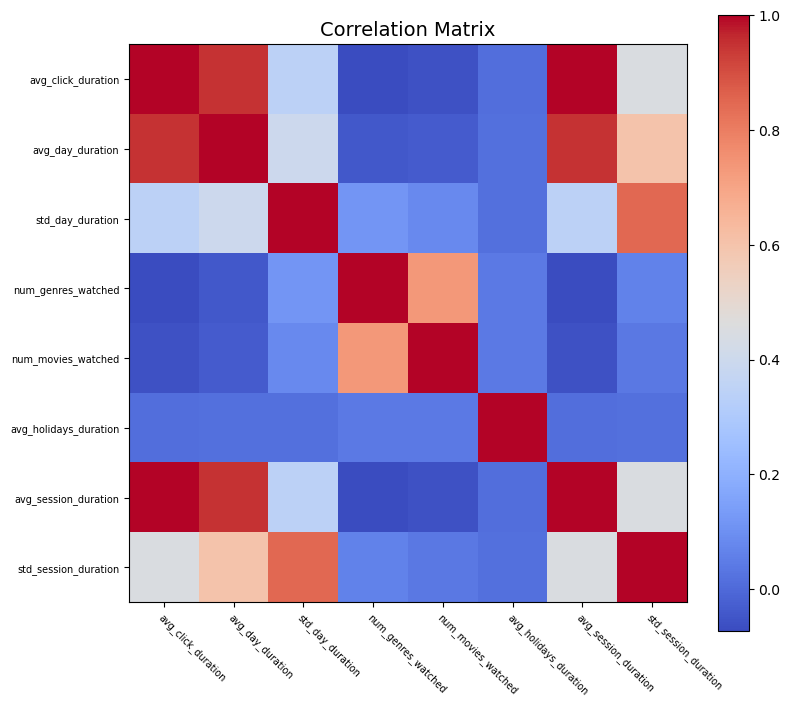

In [27]:
# Plot the correlation matrix of the normalized numeric features
pear_corr = norm_features.corr()

fig, ax = plt.subplots(figsize = (8,8))

im = ax.matshow(pear_corr, cmap=plt.get_cmap('coolwarm'))
ax.set_xticks(range(pear_corr.shape[1]), pear_corr.columns, fontsize=7, rotation = -45, ha='left', rotation_mode='anchor')
ax.set_yticks(range(pear_corr.shape[1]), pear_corr.columns, fontsize=7)
ax.set_title('Correlation Matrix', fontsize = 14)
ax.tick_params(bottom = True, labelbottom = True, top = False, labeltop = False)

fig.colorbar(im, ax=ax, orientation = 'vertical', fraction = 0.05);

It is clear that there is a strong correlation between the average time spent a day, the average time spent in a session and the average time spent for every click. There is also a quite high correlation between the number of movies and genres watched. This tells that they *may* be redundant features.

In [28]:
# PCA ON NUMERICAL VARIABLES ONLY
# Create a new dataframe including only categorical columns.
# Since the feature 'best_movie' causes some problems due to its high number of categories (nearly 5000)
# and it's associated with the 'favourite_genre', it is possible to drop it.
numeric_columns.append('best_movie')
df_normalized = df_processed.drop(numeric_columns, axis = 1)
numeric_columns.remove('best_movie')

# Define a LabelEconder object and use it to encode all the categorical variables
encoder = LabelEncoder()
for col in df_normalized.columns:
    df_normalized[col] = encoder.fit_transform(df_normalized[col])

# Now it is possible to apply PCA to reduce the number of features of the dataset
pca = PCA(n_components = 4)
pca_reducer = pca.fit(norm_features)
reduced_data = pd.DataFrame(pca_reducer.transform(norm_features), columns = ['PC1', 'PC2', 'PC3', 'PC4'])

# By performing a brief analysis of the percentage of explained variance by the components, 
# It has been chosen to keep 4 of them, retaining 94.1% of total variance
print('Explained variance by the selected principal components:', round(pca_reducer.explained_variance_ratio_.sum(),3))

# Display feature importance for each component:
# for each component it prints an array of dimension equal to the number of original features,
# where each value represents the "contribution" of feature in the component
display(pca.components_)

# Concatenate the dataset with the previously normalized features
df_normalized = pd.concat([df_normalized, reduced_data], axis = 1)

# Display the reduced dataset
display(df_normalized.head())

Explained variance by the selected principal components: 0.942


array([[ 0.48825418,  0.50226747,  0.33693736, -0.01577573, -0.01621542,
         0.01227256,  0.48825581,  0.39591954],
       [-0.10216222, -0.05554778,  0.2343083 ,  0.67031362,  0.66045955,
         0.07169607, -0.10215324,  0.17456852],
       [ 0.31767657,  0.21407124, -0.60719731,  0.20519043,  0.25396653,
         0.06833132,  0.31767391, -0.52189897],
       [-0.02088353, -0.01600105,  0.02047375, -0.06152747, -0.06550117,
         0.99500646, -0.02088214,  0.01840446]])

,favourite_genre,time_of_day,vintage,best_season,weekends_user,best_day,PC1,PC2,PC3,PC4
0,6,1,1,0,0,3,-0.704972,-0.203443,0.073396,-0.072417
1,14,0,0,0,1,3,-0.717295,0.374769,0.225679,-0.123871
2,0,0,0,0,1,3,-0.793023,2.786844,1.115050,-0.359105
3,5,0,0,0,0,3,-0.740623,3.026889,1.048751,-0.370826
4,0,0,0,0,1,3,-0.751349,0.545297,0.326791,-0.143630


### 2.3: Clustering!

The next phase concerns **clustering** of users based on their similarity. As it is an *NP-HARD* problem there are various algorithms and heuristics to do so, each one with its pros and cons. One of the most popular clustering technique is **K-Means**: it's an iterative algorithm which partitions the datapoints into an arbitrary number *K* of clusters. It's a **centroid-based algorithm**, which means that each datapoint belongs to the cluster whose centroid is the most near (usually in terms of *euclidean* distance). Each centroid is the mean of the datapoints belonging to the respective cluster. The algorithm consists in the iteration of the following steps:
- Assignment step: the distance between each datapoint and each centroid is computed. Every datapoint is assigned to the cluster corresponding to the closest centroid. It can be seen as the Map-phase in a MapReduce paradigm.
- Update step: the centroids are updated with the mean of the datapoints belonging to the respective cluster. It can be seen as the Reduce-phase in a MapReduce paradigm

These steps mathematically guarantee that the **WCSS (within-clusters sum of squared distances)** decreases at each iteration. Nevertheless, it doesn't achieve to reach the global optimum, giving only a **local optimum solution** (in fact, it stops when the change of WCSS is under a given threshold). This is caused mainly by the choice of initial centroids, which is a set of randomly sampled datapoints, and by its *greedy* approach.  
However, it is still one of the most popular clustering algorithms because of its simplicity of use. Here follows an implementation of it made *from scratch* using the *PySpark* library, which makes possible to parallelize it in a **MapReduce** paradigm:

In [29]:
# Random initialization of centroids - KMeans
def init_centroids(dframe, K, use_seed, seed):
    # Sample K random points from the dataframe, use a fixed seed whenever the user wants to
    if use_seed == True:
        sampled = dframe.rdd.takeSample(False, K, seed)
    else:
        sampled = dframe.rdd.takeSample(False, K)
    return sampled

def assign(value, centroids_broadcast):
    # This is the Map phase of the algorithm. 
    # Here, the distance between each point and each centroid is computed.
    # Each point is assigned to the cluster corresponding to the closest centroid.
    # The output is a pair where the index of the cluster is the key, and the value is
    # another tuple containing the point, the squared distance from its centroid 
    # and the value "1" (which will be used to count the cardinality of the respective cluster).
    min_dist = float('inf')
    centr = centroids_broadcast.value
    nearest_centroid = 0
    # Calculate the distance between the point and each centroid, select the closest one
    for i in range(len(centr)):
        euc_distance = np.linalg.norm(np.subtract(centr[i],value), 2)
        if euc_distance < min_dist:
            min_dist = euc_distance
            nearest_centroid = i
    return (nearest_centroid, (value,min_dist**2,1))

def summation(value_a, value_b):
    # This is the Reduce phase of the algorithm. 
    # Here, the sum of the values with the same keys is computed.
    # So, it adds up points belonging to the same cluster, their distance from the centroid, and the last value used to count them.
    # The output is a RDD composed of K rows, where each row is a tuple which contains the respective key (cluser)
    # and another tuple containing the sum of all points belonging to the respective cluster,
    # the sum of their squared distance from the centroid and their count.
    return (np.add(value_a[0],value_b[0]), np.add(value_a[1],value_b[1]), np.add(value_a[2],value_b[2]))

def average(value):
    # In this phase the points belonging to the reduced dataframe are divided by the respective count.
    # The output is a RDD composed of K rows, where each row is a tuple which contains the respective key (cluser)
    # and the associated centroid.
    return np.divide(value[0],value[2])

def evaluate_stop(lossval, niter, threshold, progress):
    # Checks if the relative variation of the loss values is below an arbitrary threshold.
    # If it's so, the algorithm stops prematurely.
    if niter in [1,2]:
        return False
    elif abs((lossval[-1] - lossval[-2])/lossval[-2]) <= threshold:
        #print('Stopped due to convergence')
        progress.container.close()
        return True
    return False

In [30]:
# Custom KMeans algorithm coded with PySpark - leverages functions defined in the previous cell
def custom_KM(dataframe, n_centroids, max_iter = 50, threshold = 1e-5, use_seed = False, seed = 81):
    
    start_time = time.time()
    
    # Initialization of random centroids
    sparkdf = spark.createDataFrame(dataframe).coalesce(1)
    centroids = init_centroids(dframe = sparkdf, K = n_centroids, use_seed = use_seed, seed = seed)
    # Centroids are broadcasted, which means that they are cached and made available to each node
    centroids_broadcast = sc.broadcast(centroids)
    
    # Setup of the partitioned dataframe. As it will used multiple times, '.persist()' is added to store 
    # its partitions in the respective nodes
    sparkdf = spark.createDataFrame(dataframe).persist()
    loss = []
    
    # Main Loop
    tqdm_iterator = tqdm(range(1,max_iter+1), desc = 'Executing K-Means', leave=False, position = 1)
    for i in tqdm_iterator:
        # Map Phase - description inside custom function code
        assignment_rdd = sparkdf.rdd.map(lambda x: assign(x, centroids_broadcast))
    
        # Reduce phase - description inside custom function code
        update_rdd = assignment_rdd.reduceByKey(summation)
        # The loss (sum of squared distances between its point and the respective cluster) 
        # is stored inside a list to record its history.
        loss.append(sum([ind[1][1] for ind in update_rdd.collect()]))
    
        # Compute and update the centroids (the reduce phase is divided in two steps)
        centroids_rdd = update_rdd.mapValues(average)
        centroids = [ind[1] for ind in centroids_rdd.collect()]
    
        # Check if the arresting condition holds
        stop = evaluate_stop(loss, i, threshold, tqdm_iterator)
    
        if (stop == False and i < max_iter):
            # Broadcast the new centroids
            centroids_broadcast = sc.broadcast(centroids)
            continue
        else:
            # Stop
            tqdm_iterator.container.close()
            break
    
    end_time = time.time()
    # Return a list containing the cluster which each point belongs,
    # the final centroids and the history of loss values
    return assignment_rdd.keys().map(lambda x: (x, )).toDF().toPandas(), centroids_broadcast.value, loss, end_time-start_time

Let's compare the algorithm made *from scratch* with more popular implementations, such as the one provided by the *scikit-learn* library. The objective will be to find the **optimal number of clusters** by running the algorithms with different number of centroids on the previously reduced dataset and compare the obtained results:

In [34]:
# Evaluate elbow rule and silouhette score. Compare scikit-learn KMeans and custom KMeans

seed = 81

# Calculate and store inertia and silhouette score for values of K under 20
sk_inertia = {}
custom_inertia = {}
sk_silhouette = {}
custom_silhouette = {}
for k in tqdm(range(2, 21)):
    # sklearn
    model = KMeans(n_clusters=k, random_state = seed)
    model.fit(df_normalized)
    sk_inertia[k] = model.inertia_
    # Calculating the silhouette score is computationally expensive, so it's calculated on a sample
    sk_silhouette[k] = silhouette_score(df_normalized, model.labels_, sample_size = 15000)
    
    # custom
    labels, final_centroids, lossvals = custom_KM(df_normalized, k, threshold = 1e-6, max_iter = 20, use_seed = True, seed = seed)
    custom_inertia[k] = lossvals[-1]
    # Calculating the silhouette score is computationally expensive, so it's calculated on a sample
    custom_silhouette[k] = silhouette_score(df_normalized, labels.to_numpy().reshape(1,-1)[0], sample_size = 15000)

  0%|          | 0/19 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/20 [00:00<?, ?it/s]

In [31]:
########## DISCLAIMER ###########
# AS THE CALCULATION OF INERTIA AND SILHOUETTE SCORES IS TIME CONSUMING
# IT WAS DECIDED TO CALCULATE THEM ONE TIME USING A SPECIFIC SEED.
# THEY ARE STORED IN THE FOLLOWING DICTIONARIES.
# YOU CAN CHECK AND VALIDATE THESE RESULTS BY RUNNING THE ABOVE CELL OF CODE.
sk_inertia = {2: 1719663.1460856795, 3: 1464404.8599544838, 4: 1273668.8853571685, 5: 1196742.178300465, 6: 1130113.0540012359, 7: 1072819.0559942673, 8: 1004361.321374144, 9: 954040.2130303633, 10: 899638.4345154508, 11: 871051.8460308583, 12: 836588.5272853695, 13: 807332.1165580997, 14: 789085.8838258544, 15: 763497.9743056188, 16: 740370.0937862765, 17: 716170.6376838645, 18: 701575.0824365811, 19: 672578.4570949073, 20: 662674.7762142003}
custom_inertia = {2: 1719663.1460856826, 3: 1464404.859954491, 4: 1273686.7463168907, 5: 1215664.4924631817, 6: 1148188.2878440118, 7: 1097853.1525699173, 8: 1055747.1341754126, 9: 1013245.1496887062, 10: 937660.1083846409, 11: 920962.4716699143, 12: 892476.3877775363, 13: 904014.4337022597, 14: 804699.9419826429, 15: 812202.3316903338, 16: 755334.0797664123, 17: 740462.1161471253, 18: 720018.7025276246, 19: 690919.050333221, 20: 685993.717658695}
sk_silhouette = {2: 0.48287788808345583, 3: 0.27319645430748773, 4: 0.2782266600721305, 5: 0.2510922358070114, 6: 0.24992628100756833, 7: 0.19998410289576646, 8: 0.20122862520218332, 9: 0.17565101822267598, 10: 0.1780544013989457, 11: 0.17686991029937502, 12: 0.17645010854682672, 13: 0.17581940282265618, 14: 0.1783014628657113, 15: 0.1658268280205674, 16: 0.1781356007807677, 17: 0.18165829295648403, 18: 0.17317822523910853, 19: 0.1802163848182883, 20: 0.17744624486760524}
custom_silhouette = {2: 0.4841125371950478, 3: 0.26954812076567397, 4: 0.27792623315955245, 5: 0.23041017164072833, 6: 0.23761992595217496, 7: 0.20483426965190443, 8: 0.1967415808980472, 9: 0.16793413946905011, 10: 0.21663256123442176, 11: 0.17269214674943742, 12: 0.15836497446466227, 13: 0.1585992000190614, 14: 0.17005077258971862, 15: 0.15170548763314914, 16: 0.17302717177355603, 17: 0.17390054460739598, 18: 0.17437278281497579, 19: 0.17423827413701384, 20: 0.17712018483891084}

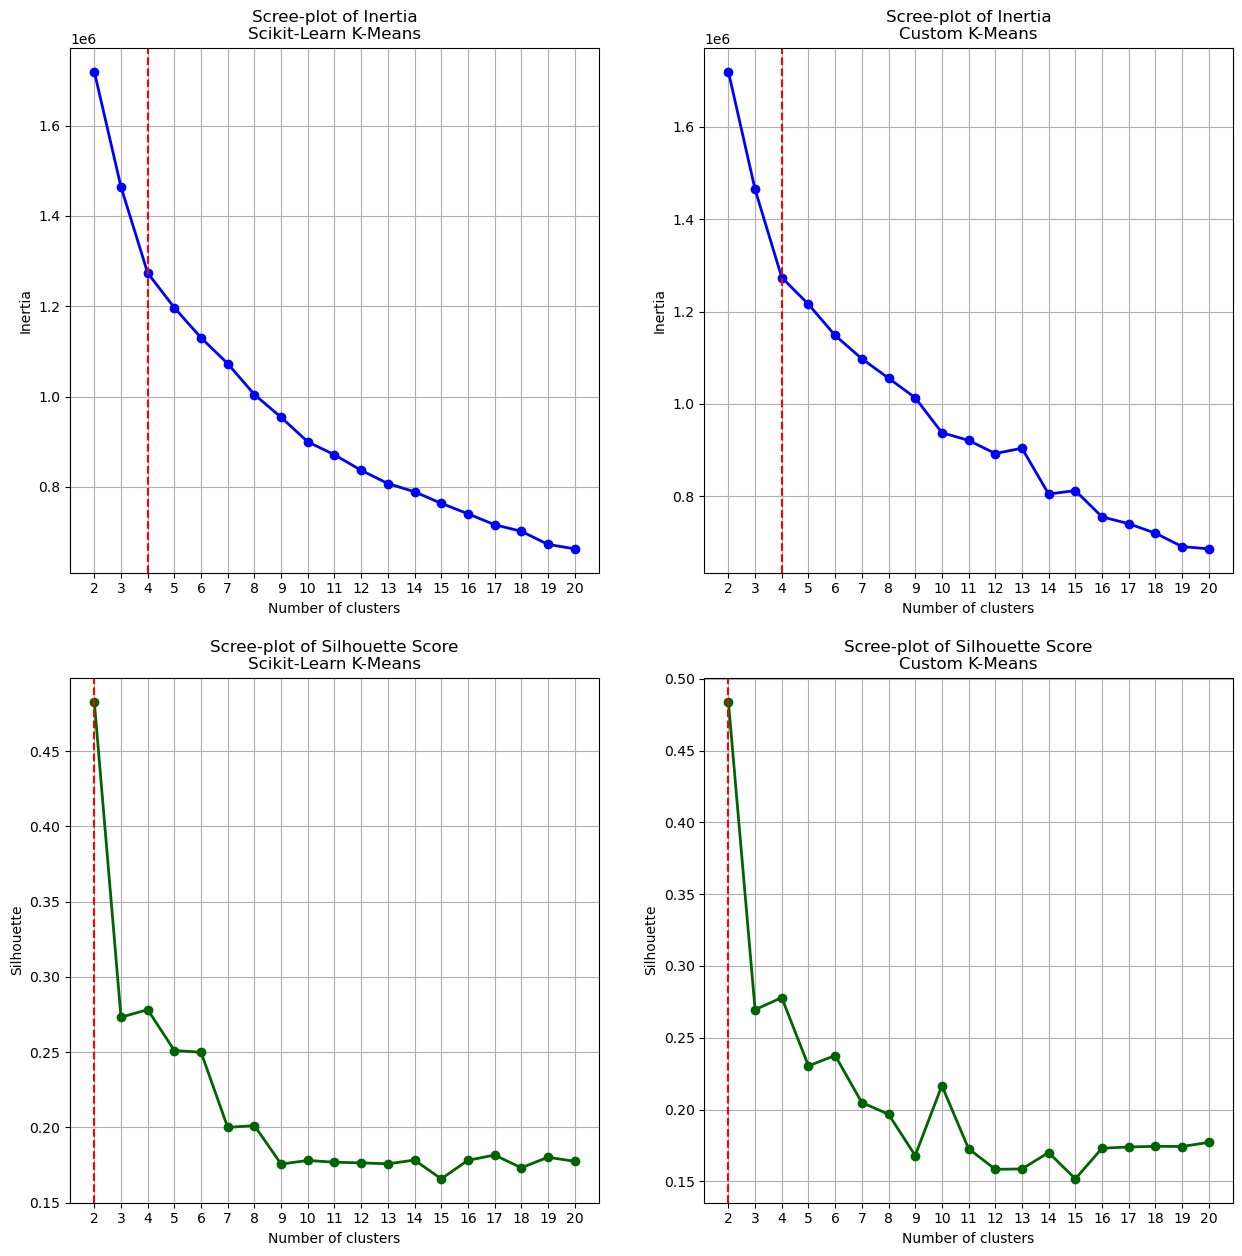

In [32]:
# Plot results (Scree plots with inertia and silhouette score)
mpl.rcParams['grid.linestyle'] = "-" # Set grid parameter
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15)) # Set number of plots

# set ticks labels (number of clusters)
xticklabels = list(sk_inertia.keys())
xticklabels.sort()

# Inertia from sklearn
axes[0][0].plot(xticklabels, list(sk_inertia.values()), marker = 'o', linewidth=2, color='blue')
axes[0][0].axvline(x = 4, color = 'red', linestyle = 'dashed')
axes[0][0].set_xlabel('Number of clusters')
axes[0][0].set_ylabel('Inertia')
axes[0][0].set_xticks(xticklabels, xticklabels)
axes[0][0].set_title('Scree-plot of Inertia\nScikit-Learn K-Means')
axes[0][0].grid(True)

# Inertia from custom algorithm
axes[0][1].plot(xticklabels, list(custom_inertia.values()), marker = 'o', linewidth=2, color='blue')
axes[0][1].axvline(x = 4, color = 'red', linestyle = 'dashed')
axes[0][1].set_xlabel('Number of clusters')
axes[0][1].set_ylabel('Inertia')
axes[0][1].set_xticks(xticklabels, xticklabels)
axes[0][1].set_title('Scree-plot of Inertia\nCustom K-Means')
axes[0][1].grid(True)

# Silhouette Score from sklearn
axes[1][0].plot(xticklabels, list(sk_silhouette.values()), marker = 'o', linewidth=2, color='darkgreen')
axes[1][0].axvline(x = 2, color = 'red', linestyle = 'dashed')
axes[1][0].set_xlabel('Number of clusters')
axes[1][0].set_ylabel('Silhouette')
axes[1][0].set_xticks(xticklabels, xticklabels)
axes[1][0].set_title('Scree-plot of Silhouette Score\nScikit-Learn K-Means')
axes[1][0].grid(True)

# Silhouette Score from custom algorithm
axes[1][1].plot(xticklabels, list(custom_silhouette.values()), marker = 'o', linewidth=2, color='darkgreen')
axes[1][1].axvline(x = 2, color = 'red', linestyle = 'dashed')
axes[1][1].set_xlabel('Number of clusters')
axes[1][1].set_ylabel('Silhouette')
axes[1][1].set_xticks(xticklabels, xticklabels)
axes[1][1].set_title('Scree-plot of Silhouette Score\nCustom K-Means')
axes[1][1].grid(True)

opt_k = 4

**Inertia** (or WCSS) and **Silhouette Score** were computed for each given number of clusters.  
The most popular rules to choose the optimal number of centroids are the *Elbow rule* and the maximization of *Silhouette Score*. The former asserts that the optimal number of centroids is in correspondence of the *elbow* of a scree plot of the **Inertia**, while the latter asserts that it is in correspondence of the maximum **Silhouette Score**.   
Taking account of the *Elbow rule* it can be observed that, in the first two plots, the suggested optimal number of clusters is 4. On the other hand, the *Silhouette Score* indicates in both cases that the optimal number of clusters is 2: it is counter-intuitive, because it leads to a way too high inertia.  
Given that, it could be stated that the **optimal number of clusters is 4** without any doubts.   
Last not least, the optimal number of clusters suggested by *scikit-learn* matches the one indicated by the algorithm made *from scratch* in all cases: this is an index of goodness of it.

In [57]:
# Let's run the custom algorithm on the reduced dataset once again, considering the optimal number of clusters
labels, final_centroids, lossvals, time_elapsed = custom_KM(df_normalized, opt_k, threshold = 1e-6, max_iter = 50, use_seed = False)

Executing K-Means:   0%|          | 0/50 [00:00<?, ?it/s]

In [58]:
print('The number of maximum iterations was 50. It stopped after '+ str(round(time_elapsed,2))+' seconds. The history of WCSS values is the following:')
print(np.around(lossvals,2))

The number of maximum iterations was 50. It stopped after 59.56 seconds. The history of WCSS values is the following:
[2916216.15 1622334.07 1402603.37 1392851.59 1392058.8  1391730.03
 1391257.43 1390703.25 1390482.26 1390203.84 1389813.3  1389063.73
 1387789.65 1385959.02 1384329.77 1383418.69 1382561.81 1381687.15
 1380699.26 1376710.89 1372798.32 1354056.37 1309568.29 1289203.33
 1280678.4  1276671.57 1274761.83 1274030.93 1273774.6  1273698.76
 1273680.9  1273670.61 1273669.4 ]


There are many variants of the KMeans algorithm. One of the most popular is the **KMeans++**, which implements a new method for selecting the initial centroids: the first centroid is randomly sampled from the dataset, while the other centroids are sampled with probability proportional to the distance from the closest centroid (among the ones already selected).  
It was demonstrated several times that this algorithm manages to achieve better results than the classical KMeans in almost all cases: in most cases it returns a solution with **less WCSS**, but in some cases it reaches the same local optimum in **much less iterations**.  
As the steps of the algorithm after the initialization remain the same, the **KMeans++** can be implemented *from scratch* in *PySpark* using a **MapReduce** paradigm:

In [33]:
# Initialization of centroids - KMeans++
def map_init(value, centroids_broadcast):
    # The minimum squared distance from the already selected centroids is computed for each datapoint
    min_dist = float('inf')
    centr = centroids_broadcast.value
    for i in range(len(centr)):
        # Calculate distance and store it, if it's the minimum
        euc_distance = np.linalg.norm(np.subtract(centr[i],value), 2)
        if euc_distance < min_dist:
            min_dist = euc_distance
    return (value, min_dist**2)

def init_centroids_pp(dframe, K, use_seed, seed):
    # Sample one random point from the dataframe, use a fixed seed whenever the user wants to
    if use_seed:
        sampled = dframe.rdd.takeSample(False, 1, seed)
    else:
        sampled = dframe.rdd.takeSample(False, 1)
    # The first centroid is broadcasted
    centroids_broadcast = sc.broadcast(sampled)
    
    # Iterate K-1 times to sample the remaining centroids
    for i in tqdm(range(K-1), 'Sampling Centroids', leave=False, position = 1):
        # Map phase - description inside custom function code
        distances = dframe.rdd.map(lambda x: map_init(x,centroids_broadcast))
    
        # Reduce phase - calculate the total sum of squared distances
        total_squared_distance = distances.map(lambda x: x[1]).reduce(lambda x, y: x + y)
    
        # Map phase - normalize the distances to get the probabilities of being sampled
        normalized_distances = distances.map(lambda x: (x[0], x[1] / total_squared_distance))
    
        # Use numpy to sample the index of the new centroid based on the normalized distance
        # use a fixed seed whenever the user wants to
        probabilities = normalized_distances.map(lambda x: x[1]).collect()
        if use_seed:
            np.random.seed(seed+i)
            new_centroid_index = np.random.choice(np.arange(len(probabilities)), size=1, replace=False, p=probabilities)
        else:
            new_centroid_index = np.random.choice(np.arange(len(probabilities)), size=1, replace=False, p=probabilities)
        new_centroid = normalized_distances.take(new_centroid_index.item(0))[-1][0]
    
        # Filter out the selected centroid from the original dataframe, to prevent it from being sampled again
        filter_condition = ~(reduce(lambda acc, col: acc & (dframe[col] == new_centroid[col]), dframe.columns, lit(True)))
        dframe = dframe.filter(filter_condition)
    
        # Add the new centroid to the list of centroids and broadcast them
        sampled.append(new_centroid)
        centroids_broadcast = sc.broadcast(sampled)
    
    return centroids_broadcast.value

In [34]:
# Custom KMeans++ algorithm coded with PySpark - leverages functions defined in the previous cell
# and some functions already used in KMeans
def custom_KM_pp(dataframe, n_centroids, max_iter = 50, threshold = 1e-5, use_seed = False, seed = 81):
    
    start_time = time.time()
    
    # Initialization of centroids, sampling proportionally to minimum squared distance from already selected centroids
    centroids = init_centroids_pp(spark.createDataFrame(dataframe).coalesce(1), K = n_centroids, use_seed = use_seed, seed = seed)
    # The centroids are broadcasted
    centroids_broadcast = sc.broadcast(centroids)
    
    # Setup of the partitioned dataframe. As it will used multiple times, '.persist()' is added to store 
    # its partitions in the respective nodes
    sparkdf = spark.createDataFrame(dataframe).persist()
    loss = []
    
    # Main Loop
    tqdm_iterator = tqdm(range(1,max_iter+1), desc = 'Executing K-Means', leave=False, position = 1)
    for i in tqdm_iterator:
        # Map Phase - description inside custom function code
        assignment_rdd = sparkdf.rdd.map(lambda x: assign(x, centroids_broadcast))
    
        # Reduce phase - description inside custom function code
        update_rdd = assignment_rdd.reduceByKey(summation)
        # The loss (sum of squared distances between its point and the respective cluster) 
        # is stored inside a list to record its history.
        loss.append(sum([ind[1][1] for ind in update_rdd.collect()]))
    
        # Compute and update the centroids (the reduce phase is divided in two steps)
        centroids_rdd = update_rdd.mapValues(average)
        centroids = [ind[1] for ind in centroids_rdd.collect()]
    
        # Check if the arresting condition holds
        stop = evaluate_stop(loss, i, threshold, tqdm_iterator)
    
        if (stop == False and i < max_iter):
            # Broadcast the new centroids
            centroids_broadcast = sc.broadcast(centroids)
            continue
        else:
            # Stop
            tqdm_iterator.container.close()
            break
    
    end_time = time.time()
    # Return a list containing the cluster which each point belongs,
    # the final centroids and the history of loss values
    return assignment_rdd.keys().map(lambda x: (x, )).toDF().toPandas(), centroids_broadcast.value, loss, end_time-start_time

Let's test and compare it against the classic **KMeans**:

In [55]:
# Run KMeans++ with 'opt_k' and explain differences
labels_pp, final_centroids_pp, lossvals_pp, time_elapsed_pp = custom_KM_pp(df_normalized, opt_k, threshold = 1e-6, max_iter = 50, use_seed = False)

Sampling Centroids:   0%|          | 0/3 [00:00<?, ?it/s]

Executing K-Means:   0%|          | 0/50 [00:00<?, ?it/s]

In [56]:
print('The number of maximum iterations was 50. It stopped after '+ str(round(time_elapsed_pp,2))+' seconds. The history of WCSS values is the following:')
print(np.around(lossvals_pp,2)) # Same local optima but it found it in much less iterations

The number of maximum iterations was 50. It stopped after 65.76 seconds. The history of WCSS values is the following:
[2058142.91 1452217.53 1386193.65 1327356.8  1295561.05 1283609.53
 1278097.05 1275364.76 1274232.78 1273833.51 1273716.91 1273683.31
 1273671.1  1273669.3  1273668.89]


As expected, the **KMeans++** provided the same result in less iterations (but it took more time because of the initialization, which I think isn't really optimized at its best in this implementation). Taking account of its solution, the final dataset would be:

In [35]:
########## DISCLAIMER ########### 
# KMEANS++ WAS RUN WITHOUT SEED AND THE RESULT HANDED IN CSV FORMAT
# TO ANOTHER GROUP MEMBER IN ORDER TO MAKE HIM ABLE TO DO PART 2.4.
# TO AVOID DISCREPANCIES, THE SAME DATASET WILL BE IMPORTED FROM A CSV FILE.
clustered_df = pd.read_csv('final_dataset.csv')
display(clustered_df.head())

,favourite_genre,time_of_day,vintage,best_season,weekends_user,best_day,PC1,PC2,PC3,PC4,cluster
0,6,1,1,0,0,3,-0.704972,-0.203443,0.073396,-0.072417,3
1,14,0,0,0,1,3,-0.717295,0.374769,0.225679,-0.123871,0
2,0,0,0,0,1,3,-0.793023,2.786844,1.115050,-0.359105,2
3,5,0,0,0,0,3,-0.740623,3.026889,1.048751,-0.370826,3
4,0,0,0,0,1,3,-0.751349,0.545297,0.326791,-0.143630,2


It was asked ChatGPT to recommend other clustering algorithms based on a sample of the dataset. It suggested the following algorithms:
- **K-Modes**: an extension of K-Means for categorical data. It works with categorical data by defining modes (most frequent categories) for each cluster.
- **K-Prototype**: an extension of K-Means that can handle both numerical and categorical data. It combines K-Means for numerical data and K-Modes for categorical data.

It was decided to use the **K-Prototype** algorithm, because it seems to be more suitable to the dataset to analyze. It's provided by the *kmodes* library:

In [36]:
# Store names of categorical features and set their type as 'object'
categorical_columns = ['favourite_genre', 'time_of_day', 'vintage', 'best_season', 'weekends_user', 'best_day']
df_normalized_prot = df_normalized
df_normalized_prot[categorical_columns] = df_normalized[categorical_columns].astype(str)

# Fit K-Prototypes
kproto = KPrototypes(n_clusters=opt_k, init='Cao', n_jobs = -1, n_init = 1, max_iter = 50)
clusters = kproto.fit_predict(df_normalized_prot, categorical=[0,1,2,3,4,5])

In [37]:
display(kproto.cost_)

617720.5977188741

As it can be seen, the final inertia of the **K-Prototype** algorithm is much lower than the one found with the solution returned by the **KMeans** and **KMeans++** algorithms. This is indeed a better solution, whose is found because the algorithm itslef is designed to handle both numerical and categorical data. Here follows also the first few lines of the dataset clustered with this algorithm:

In [46]:
# Create a new dataframe with the 'cluster' column
clustered_df_prot = pd.concat([df_normalized_prot, pd.DataFrame(data = clusters, columns = ['cluster'])], axis = 1)
display(clustered_df_prot.head())

,favourite_genre,time_of_day,vintage,best_season,weekends_user,best_day,PC1,PC2,PC3,PC4,cluster
0,6,1,1,0,0,3,-0.704972,-0.203443,0.073396,-0.072417,0
1,14,0,0,0,1,3,-0.717295,0.374769,0.225679,-0.123871,0
2,0,0,0,0,1,3,-0.793023,2.786844,1.115050,-0.359105,3
3,5,0,0,0,0,3,-0.740623,3.026889,1.048751,-0.370826,3
4,0,0,0,0,1,3,-0.751349,0.545297,0.326791,-0.143630,0


## 2.4 Analysing your results!

Cluster Characterization:

    Time_of_day:
        Afternoon Cluster (0): Customers who engage during the afternoon.
        Evening Cluster (1): Customers who engage during the evening.
        Morning Cluster (2): Customers who engage during the morning hours.
        Night Cluster (3): Customers who engage at night.

    Best_season:
        Spring Cluster (0): Customers who prefer the spring season.
        Summer Cluster (1): Customers who prefer the summer season.
        Autumn Cluster (2): Customers who prefer the autumn season.
        Winter Cluster (3): Customers who prefer the winter season.

In [48]:
# Categorize time_of_day
time_of_day_categories = {
    0: 'Morning Cluster',
    1: 'Evening Cluster',
    2: 'Afternoon Cluster',
    3: 'Night Cluster'
}

df['time_of_day_category'] = df['time_of_day'].map(time_of_day_categories)

# Categorize best_season
best_season_categories = {
    0: 'Spring Cluster',
    1: 'Summer Cluster',
    2: 'Autumn Cluster',
    3: 'Winter Cluster'
}

df['best_season_category'] = df['best_season'].map(best_season_categories)

# Pivot table for time_of_day
time_of_day_pivot = pd.pivot_table(df, values='time_of_day', index='time_of_day_category', columns='cluster', aggfunc='count', fill_value=0)
time_of_day_pivot_percentage = time_of_day_pivot.div(time_of_day_pivot.sum(axis=0), axis=1) * 100

# Pivot table for best_season
best_season_pivot = pd.pivot_table(df, values='best_season', index='best_season_category', columns='cluster', aggfunc='count', fill_value=0)
best_season_pivot_percentage = best_season_pivot.div(best_season_pivot.sum(axis=0), axis=1) * 100

# Print the results
display("Time_of_day Pivot Table (Percentage):")
display(time_of_day_pivot_percentage)

display("Best_season Pivot Table (Percentage):")
display(best_season_pivot_percentage)


'Time_of_day Pivot Table (Percentage):'

cluster,0,1,2,3
time_of_day_category,,,,
Afternoon Cluster,11.644262,12.078775,12.965070,12.676832
Evening Cluster,47.631977,49.978118,44.797776,47.492707
Morning Cluster,28.799074,28.227571,29.488751,28.810481
Night Cluster,11.924686,9.715536,12.748402,11.019981


'Best_season Pivot Table (Percentage):'

cluster,0,1,2,3
best_season_category,,,,
Autumn Cluster,23.555595,25.295405,22.977764,21.269335
Spring Cluster,28.678893,23.107221,23.824740,27.035284
Summer Cluster,31.189353,31.772429,35.754618,31.526944
Winter Cluster,16.576160,19.824945,17.442878,20.168437


Pivot Table for Time of Day (Percentage):

    Afternoon Cluster (2): I can see that this cluster has a fairly balanced distribution throughout the day, but there is a slight increase in engagement during the afternoon hours for all clusters.

    Evening Cluster (1): It is evident that this cluster represents customers who are more active in the evening. Percentages range from 44.80% to 49.98%, indicating a strong preference for interaction during the evening hours.

    Morning Cluster (0): This cluster shows a consistent engagement pattern during the morning hours, with percentages ranging from 28.23% to 29.49%. It seems that these customers prefer to interact in the morning.

    Night Cluster (3): I notice a balanced distribution across different times of the day, with a slight inclination towards interaction at night. It suggests that this cluster is also active during the night.

Pivot Table for Preferred Season (Percentage):

    Autumn Cluster (2): The distribution here is quite balanced, with a slight inclination towards the autumn season. It seems that customers in this cluster have a slight preference for interaction during autumn.

    Spring Cluster (0): This cluster indicates a clear preference for the spring season, with percentages ranging from 23.11% to 28.68%. Customers in this group seem to prefer spring.

    Summer Cluster (1): The summer season stands out for this cluster, with percentages ranging from 31.19% to 35.75%. It is evident that these customers are more active during the summer.

    Winter Cluster (3): This cluster shows a balanced distribution, with a slight preference for the winter season. It suggests that customers in this group might prefer to interact during the winter months.

Algorithm Clustering Performance:

From my perspective, the clustering algorithm seems to have achieved fairly good results. The identified clusters align with expectations based on the time of day and preferred seasons. The percentages in the pivot tables provide information about the strength of these preferences within each cluster.

## 3. Bonus Question

DBSCAN for the analysis on the provided dataset.

In [ ]:

# Select relevant features for clustering
features = df_normalized[['PC1', 'PC2', 'PC3', 'PC4']]

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You may need to adjust eps and min_samples
df_normalized['dbscan_labels'] = dbscan.fit_predict(features)

# Visualize the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='dbscan_labels', data=df_normalized, palette='viridis', legend='full')
plt.title('DBSCAN Clustering Results')
plt.show()

ChatGPT:

Certainly! Here are three density-based clustering algorithms:

    DBSCAN (Density-Based Spatial Clustering of Applications with Noise):
        DBSCAN is a widely used density-based clustering algorithm.
        It defines clusters as continuous regions of high point density, separated by regions of lower point density.
        It is effective in discovering clusters of arbitrary shapes and is less sensitive to outliers.

    OPTICS (Ordering Points To Identify Clustering Structure):
        OPTICS is an extension of DBSCAN that produces a reachability plot.
        It allows for the identification of clusters with varying densities and provides a hierarchical view of the clusters.
        It is particularly useful when dealing with datasets containing clusters of different shapes and sizes.

    HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise):
        HDBSCAN is an improvement over DBSCAN that produces a hierarchy of clusters.
        It can automatically determine the number of clusters, making it more flexible.
        It is robust to variations in cluster density and provides a detailed cluster hierarchy.

# 4. Command Line Question

The executable script file and the output screen can be found in the repository under the name CommandLine.sh and CommandLine.png. Below I put the text of the file for easier reading and understanding.

```bash
#!/bin/bash
input_file="vodclickstream_uk_movies_03.csv"

# 1. What is the most-watched Netflix title?
# group by the uniques titles and count the number of occurrences, saving them in a txt file
awk -F ',' '{print $4}' $input_file | sort | uniq -c | sort -nr > title_count.txt
# get the title from the txt file
most_watched_title=$(head -n 1 title_count.txt | awk '{$1=""; print $0}' | sed 's/^ *//')
echo "Most watched title: $most_watched_title"

# 2. The average time of subsequent clicks on Netflix.com
# filtering the duration tha has to be >= 0.0 and saving the values in a new file
awk -F ',' '{ if ($3 >= 0.0) print $0 }' $input_file > filtered_duration.csv
# the sum of duration (column 3) and the average of them
avg_duration=$(awk -F ',' '{print $3}' filtered_duration.csv | awk '{sum += $1} END {print sum/NR}')
# convert the duration from seconds to minutes
avg_min=$(awk -v avg_duration="$avg_duration" 'BEGIN { avg_min = avg_duration / 60; printf "%.2f\n", avg_min }')
# print the result
echo "Average duration of subsequent clicks: $avg_min minutes"

# 3. ID of the user that has spent the most time on Netflix
# group by the user_id and sum the duration time of each user, then sorting them and saving them in a txt file
awk -F ',' 'NR>1 { sum[$NF] += $3 } END { for (i in sum) print i, sum[i] }' filtered_duration.csv | sort -k2,2nr > sorted_users.txt
# get the user_id from the txt file
high_time_user=$(head -n 1 sorted_users.txt | awk '{print $1}')
echo "The user that has spent the most time on Netflix: $high_time_user"
```

1. To get the most watched Netflix title, we first grouped by each title in the dataset, then counted each time this appeared and saved the results in descending order in a new file, called ```title_count.txt```. At the end we extracted the first title of the file previusly created.
2. The average time of subsequent clicks on Netflix, we interpreted it as the average of all the duration times in the column 'duration' of the dataset, since it represents how much time the user stayed on the title, so each value corresponds to one click. Sais this, we filtered the dataset taking into account only the durations that are not negative, then summed all the remaining and took the average. Finally we converted the result from seconds to minutes.
3. The id of the user that has spent the most time on netflix has been extracted by first grouping the dataset by each user id, then summing the durations of each one and sorting them in descending order in a file, called ```sorted_users.txt```. At the end we extracted the first user in the file just created.

The following are the results

![CommandLine](CommandLine.png)

# 5. Algorithmic Question

He was given an initial personal score of when he enrolled ***S***, which changes every time he takes an exam.\
Every of the exams he has to take is assigned a mark ***p***.\
Once he has chosen an exam, his score becomes equal to the mark **S = p**, and at the same time, the scoring system changes:
- If he takes an "easy" exam (the score of the exam being less than his score), every other exam's mark is increased by
the quantity **$S-p$**.
- If he takes a "hard" exam (the score of the exam is greater than his score), every other exam's mark is decreased by
the quantity **$p-S$**.
- The exam score can't be negative, so if in any update a mark goes below zero it must be collapsed to zero.

He wants to know which is the highest score possible he could get.


In [1]:
import itertools

In [2]:
def FedericosScore(S, marks, p):

    copy_marks = marks.copy()                                             # T(n)

    if len(copy_marks) == 1:   # base case                                # T(1)
        return copy_marks[0]                                              

    if p <= S: # easy exam                                                # T(1)
        copy_marks.pop(0)                                                 # T(n)
        copy_marks = [x+(S-p) if x+(S-p)>=0 else 0 for x in copy_marks]   # T(n) 
        S = p                                                             # T(1)

    else: # hard exam                                                     # T(n)
        copy_marks.pop(0)
        copy_marks = [x-(p-S) if x-(p-S) >= 0 else 0 for x in copy_marks] #T(n) 
        S = p
        
    return FedericosScore(S, copy_marks, copy_marks[0])                   # T(n-1) 


In [4]:
# input 1
S = 8
marks = [5, 7, 1]

permutations = [list(x) for x in itertools.permutations(marks, len(marks))] # all the possible permutations of the exams O(n!)

scores = {}
for permu in permutations:
    scores[FedericosScore(S=S, marks=permu, p=permu[0])] = permu
max_s = max(scores.keys())
print(f'The highest score Federico can get is: {max_s} with this oder: {scores[max_s]}')

The highest score Federico can get is: 11 with this oder: [7, 1, 5]


In [5]:
# input 2
S = 25
marks = [18, 24, 21, 32, 27]

#FedericosScore(S, marks, marks[0])

permutations = [list(x) for x in itertools.permutations(marks, len(marks))] # all the possible permutations of the exams 

scores = {}
for permu in permutations:
    scores[FedericosScore(S=S, marks=permu, p=permu[0])] = permu
max_s = max(scores.keys())
print(f'The highest score Federico can get is: {max_s} with this order: {scores[max_s]}')

The highest score Federico can get is: 44 with this order: [27, 21, 32, 18, 24]


In [ ]:
# input 3
S = 30
marks = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]

permutations = [list(x) for x in itertools.permutations(marks, len(marks))] # all the possible permutations of the exams 

# memory exceeded

scores = {}
for permu in permutations:
    scores[FedericosScore(S=S, marks=permu, p=permu[0])] = permu
max_s = max(scores.keys())
print(f'The highest score Federico can get is: {max_s} with this order: {scores[max_s]}')

The idea behind this initial solution is to have a function, ```FedrericosScore```, that takes in input:
- ```S```: the initial score of the student
- ```marks```: the list of the exams' marks
- ```p```: the first exam's mark

Then, since the student can choose the order of the esams he can take, we compute all the possible $n!$ permutations of the exams and give them in input, one by one, to the function.\
The result will be stored in a dictionary with keys the score and as vaulues the specific permutation that will make the student obstain that final score.\
Finally, we take the maximum score, out of the dictionary's keys, and its associated value; in this way the student will know in which order he has to take its exams in order to obtain the maximum score possible.

time complexity of the function:\
Assuming $n$ is the lenght of the ```marks``` list
- ```copy_marks``` has a time complexity of $T(n)$
- ```if len(copy_marks) == 1``` has a constant time complexity $T(1)$
- ```if p <= S:``` has a total time complexity of $T(n)$, since it has to pop the first element, shifting all the others, and in the list comprehension has to iterate on all the elements of the list.
- ```else:``` has a total time complexity of $T(n)$ for the same reason above.
- ```return FedericosScore``` has a time complexity of $T(n-1)$ in the worst case, since depends on the number of elements left in the list.

The total running time $T(n)$ can be expressed as:
\begin{align*}
T(n) =
\begin{cases} 
n+1 & \text{ if $n = 1$} \\
T(n-1)+5n+1 & \text{ if $n>1$} 
\end{cases}
\end{align*}
Generalizing we'll have a $T(n-i)+(5 \cdot i)n + i$, which at the end will result in $T(n) = 5n^2 - 3n + 2 \implies O(n^2)$.  

So the function has a quadratic time complexity of $O(n^2)$, then it has to be applied $n!$ times, for each one of the permutations of the list, so at the end the whole algorithm will have a complexity of $O(n^2 \cdot n!)$

This can't be sustainbable, since is highly memory-comsuming computing all the $n!$ permutations of a list as $n$ grows; for this reason this method doesn't work on the ```intput 3``` since has $n=12$ elements and all its permutations will be $479.001.600$. 

## Optimization

In [7]:
def Federicos_score_opt(S, marks):

    if len(marks) == 0:                                                                # T(1)     
        return S                                                                       # T(1)     
    
    maxScore = 0  # keep track of the maximum score Federico can achieve               # T(1)
    for i, mark in enumerate(marks):                                                   # T(n) 
        update_marks = marks[:i] + marks[i+1:] # don't consider the current exam       # T(n) 
        newScore = mark                                                                # T(1)
        if mark <= S: # esasy exam                                                     # T(1)
            update_marks = [x+(S-mark) if x+(S-mark)>=0 else 0 for x in update_marks]  # T(n)
        else: # hard exam
            update_marks = [x-(mark-S) if x-(mark-S)>=0 else 0 for x in update_marks]  # T(n)

        # comparing the current maxScore with the result of the recursive call.
        maxScore = max(maxScore, Federicos_score_opt(newScore, update_marks))          # T(n-1)
    return maxScore                                                                    # T(1)

In [8]:
# input 1
S_1 = 8
p_1 = [5, 7, 1]
result_1 = Federicos_score_opt(S_1, p_1)
print("Output 1:", result_1)

Output 1: 11


In [12]:
S_2 = 25
p_2 = [18, 24, 21, 32, 27]
result_2 = Federicos_score_opt(S_2, p_2)
print("Output 2:", result_2)

Output 2: 44


In [11]:
S_3 = 30
p_3 = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
result_3 = Federicos_score_opt(S_3, p_3)
print("Output 3:", result_3)

# took 16 mins

Output 3: 109


In this solution we don't have to explicitally compute all the possible permutations of the exams, because the optimized function explores all possible combinations of the exams recursivly and eventually finds the combination that guarantees the highest score possible by exploring different paths for each exam in the list. 

Time complexity of the function:\
Assuming $n$ is the lenght of the ```marks``` list
- ```if len(copy_marks) == 1``` has a constant time complexity $T(1)$
- ```for i, mark in enumerate(marks)``` has a linear time of $T(n)$ because we iterate through all the exams
- ```update_marks = marks[:i] + marks[i + 1:]``` has a linear time complexity $T(n)$ since we're performing a list slicing
- ```if mark <= S``` loop has a total complexity of $T(n)$ since the list comprehension inside explores all the elements in the list
- ```else``` loop has the complexity of $T(n)$ for the same reason above
- ```maxScore = max(maxScore, Federicos_score_opt(newScore, update_marks))``` has a time complexity of $T(n-1)$ in the worst case, since depends on the number of elements left in the list.

Since the recursive call of the function is inside the loop of complexity $O(n^2)$, this significantly contributes to the overall complexity of the function, that is $O(n^3)$.\
This is an improvement in respect to the previus algorithm, both on time complexity and memory complexity, since we're now able to actually see a result for the exam's list of the third input.

# ChatGPT optimization implementation 

In [31]:
def Federicos_score_chatGPT(S, marks, store={}):
    if len(marks) == 0:
        return S

    if (S, tuple(marks)) in store:
        return store[(S, tuple(marks))]

    maxScore = 0
    for i, mark in enumerate(marks):
        update_marks = marks[:i] + marks[i + 1:]
        newScore = mark
        if mark <= S:
            update_marks = [x + (S - mark) if x + (S - mark) >= 0 else 0 for x in update_marks]
        else:
            update_marks = [x - (mark - S) if x - (mark - S) >= 0 else 0 for x in update_marks]

        maxScore = max(maxScore, Federicos_score_chatGPT(newScore, update_marks, store))

    store[(S, tuple(marks))] = maxScore
    return maxScore


In [32]:
# input 1
S_1 = 8
p_1 = [5, 7, 1]
result_1 = Federicos_score_chatGPT(8, [5,7,1])
print("Output 1:", result_1)

Output 1: 11


In [29]:
S_2 = 25
p_2 = [18, 24, 21, 32, 27]
result_2 = Federicos_score_chatGPT(S_2, p_2)
print("Output 2:", result_2)

Output 2: 44


In [30]:
S_3 = 30
p_3 = [13, 27, 41, 59, 28, 33, 39, 19, 52, 48, 55, 79]
result_3 = Federicos_score_chatGPT(S_3, p_3)
print("Output 3:", result_3)

# took 2.5 seconds

Output 3: 109


Optimization Approach:

- **Memoization**: Introduced a memoization dictionary (```store```) to store previously computed results for combinations of ```S``` and ```marks```. This prevents redundant calculations by checking if a specific combination has been encountered before. If so, it retrieves the result from memo instead of recomputing it.

- **Avoidance of Recomputation**: By storing and retrieving results from the ```store``` dictionary, the function bypasses the need to recompute solutions for the same combination of ```S``` and ```marks```. This significantly reduces the number of recursive calls and computations required, leading to a more efficient algorithm overall.

This optimization effectively reduces the time complexity of the algorithm from $O(n^3)$ to $O(n^2)$ by avoiding redundant computations through memoization.